In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from tqdm import tqdm
import itertools

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.distributions_pt import GMM #random_tilted_gaussian, Gaussian, GMM, RoughWell
from utils.notebook_utils_pt import get_hmc_samples, plot_gaussian_contours

import seaborn as sns
sns.set_palette("muted")

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from func_utils_pt import acl_spectrum, ESS

In [4]:
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples
import random

from IPython.core.debugger import set_trace

In [5]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(0)   
# random.seed(0)

In [6]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

---
# Network architecture

In [7]:
network = Net


---
# Mixture of Gaussians (MoG)

## Defining the distribution

We define our energy function. It is a Gaussian distribution with zero mean. The covariance is a $\pi/4$ rotation of the eigenvalues $[100, 10^{-1}]$. We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [8]:
x_dim = 2
mu_1 = np.array([-2., 0.])
mu_2 = np.array([2., 0.])
mus = torch.tensor(np.array([mu_1, mu_2]), dtype=torch.float32, device=device)
cov_1 = 0.1 * np.eye(2)
cov_2 = 0.1 * np.eye(2)
covs = torch.tensor(np.array([cov_1, cov_2]), dtype=torch.float32, device=device)
pis = np.array([0.5, 0.5])
dist = GMM(mus, covs, pis, device=device)

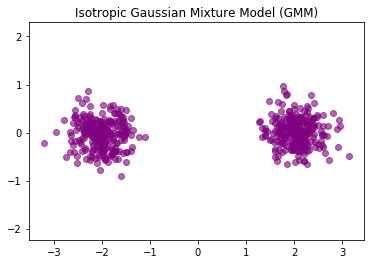

In [9]:
S = dist.get_samples(500)
fig = plt.figure()
plt.title('Isotropic Gaussian Mixture Model (GMM)')
# plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-3,3], y_lims=[-2,2])
plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=c_true)
plt.axis('equal')
plt.show()
# fig.savefig('iso_gmm_exact.png', dpi=200)

---
## Training

In [10]:
dynamics = Dynamics(x_dim, dist.get_energy_function(), T=10, eps=0.1, net_factory=network, use_temperature=True, device=device).to(device)

/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/dynamics_pt.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Temp = torch.tensor(self.temperature, dtype=torchType, device=device)


In [11]:
n_steps = 5000
n_samples = 200
use_barker = False   

  0%|          | 0/5000 [00:00<?, ?it/s]

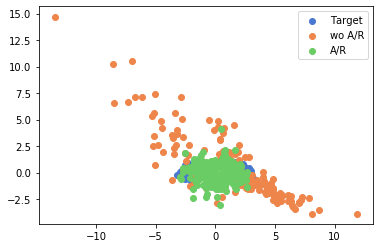

  0%|          | 1/5000 [00:00<38:45,  2.15it/s]

Step: 0 / 5000, Loss: 6.93e+02, Acceptance sample: 0.22, LR: 0.00100


  1%|          | 50/5000 [00:19<31:53,  2.59it/s]

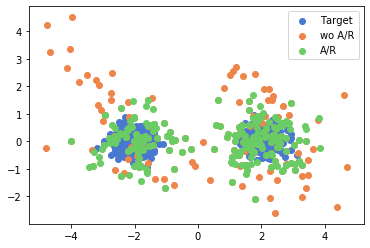

  2%|▏         | 100/5000 [00:38<31:14,  2.61it/s]

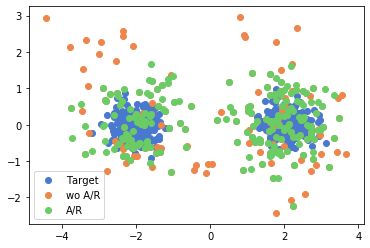

  2%|▏         | 101/5000 [00:39<33:40,  2.42it/s]

Step: 100 / 5000, Loss: -1.24e+01, Acceptance sample: 0.65, LR: 0.00100


  3%|▎         | 150/5000 [00:58<31:13,  2.59it/s]

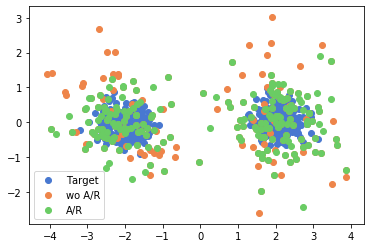

  4%|▍         | 200/5000 [01:17<30:37,  2.61it/s]

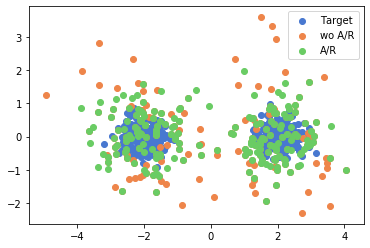

  4%|▍         | 201/5000 [01:18<32:56,  2.43it/s]

Step: 200 / 5000, Loss: -6.92e+00, Acceptance sample: 0.66, LR: 0.00100


  5%|▌         | 250/5000 [01:36<30:02,  2.63it/s]

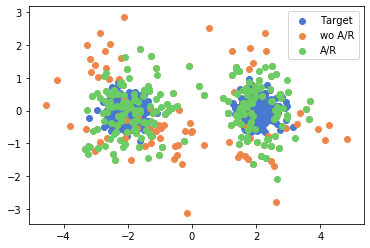

  6%|▌         | 300/5000 [01:56<30:10,  2.60it/s]

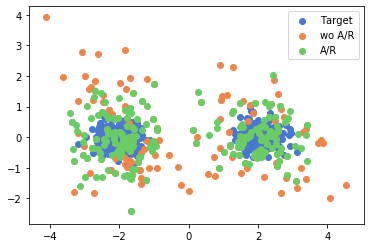

  6%|▌         | 301/5000 [01:56<32:25,  2.42it/s]

Step: 300 / 5000, Loss: -9.87e+00, Acceptance sample: 0.58, LR: 0.00100


  7%|▋         | 350/5000 [02:15<29:41,  2.61it/s]

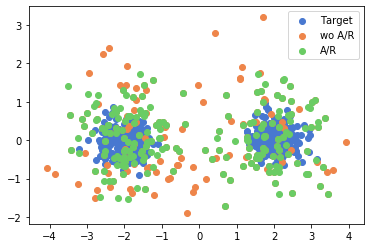

  8%|▊         | 400/5000 [02:34<29:20,  2.61it/s]

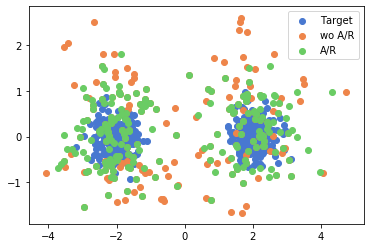

  8%|▊         | 401/5000 [02:35<31:24,  2.44it/s]

Step: 400 / 5000, Loss: -1.80e+01, Acceptance sample: 0.57, LR: 0.00100


  9%|▉         | 450/5000 [02:54<28:53,  2.63it/s]

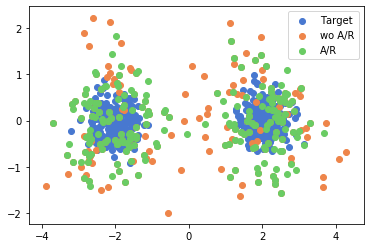

 10%|█         | 500/5000 [03:13<28:44,  2.61it/s]

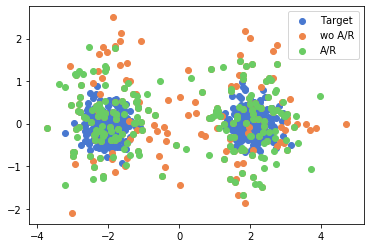

 10%|█         | 501/5000 [03:14<30:49,  2.43it/s]

Step: 500 / 5000, Loss: -3.26e+01, Acceptance sample: 0.56, LR: 0.00100


 11%|█         | 550/5000 [03:33<28:52,  2.57it/s]

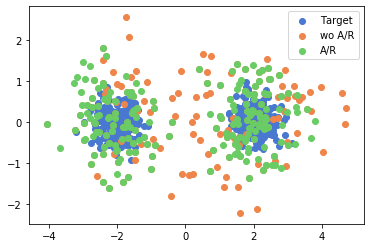

 12%|█▏        | 600/5000 [03:52<28:13,  2.60it/s]

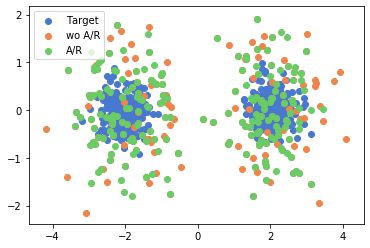

 12%|█▏        | 601/5000 [03:53<30:51,  2.38it/s]

Step: 600 / 5000, Loss: -5.75e+01, Acceptance sample: 0.62, LR: 0.00100


 13%|█▎        | 650/5000 [04:12<27:59,  2.59it/s]

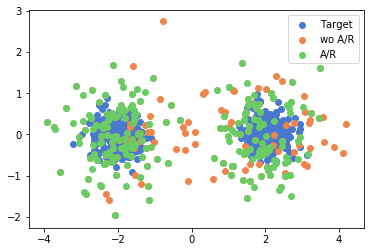

 14%|█▍        | 700/5000 [04:31<27:35,  2.60it/s]

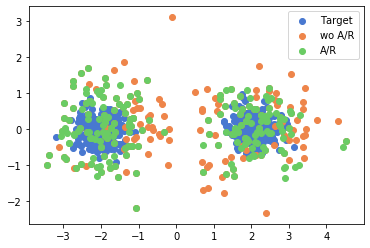

 14%|█▍        | 701/5000 [04:32<30:12,  2.37it/s]

Step: 700 / 5000, Loss: -5.87e+01, Acceptance sample: 0.56, LR: 0.00100


 15%|█▌        | 750/5000 [04:50<27:14,  2.60it/s]

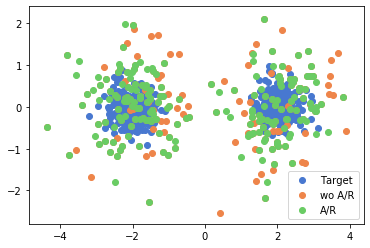

 16%|█▌        | 800/5000 [05:10<27:08,  2.58it/s]

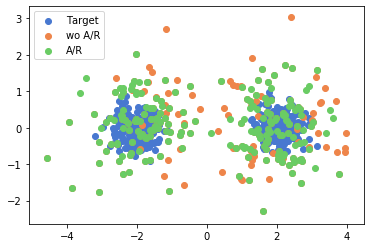

 16%|█▌        | 801/5000 [05:10<29:56,  2.34it/s]

Step: 800 / 5000, Loss: -6.28e+01, Acceptance sample: 0.64, LR: 0.00100


 17%|█▋        | 850/5000 [05:29<26:49,  2.58it/s]

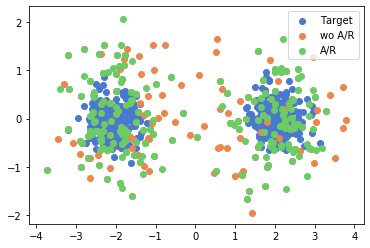

 18%|█▊        | 900/5000 [05:49<26:58,  2.53it/s]

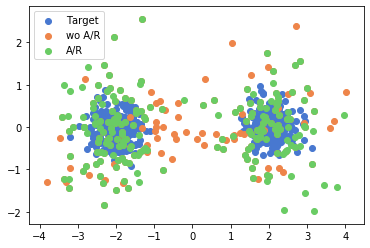

 18%|█▊        | 901/5000 [05:49<29:28,  2.32it/s]

Step: 900 / 5000, Loss: -6.82e+01, Acceptance sample: 0.75, LR: 0.00100


 19%|█▉        | 950/5000 [06:09<26:28,  2.55it/s]

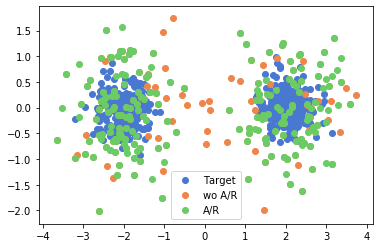

 20%|██        | 1000/5000 [06:28<25:51,  2.58it/s]

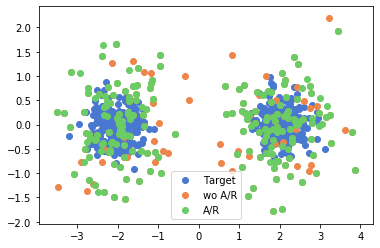

 20%|██        | 1001/5000 [06:29<28:10,  2.37it/s]

Step: 1000 / 5000, Loss: -8.48e+01, Acceptance sample: 0.79, LR: 0.00096


 21%|██        | 1050/5000 [06:48<25:20,  2.60it/s]

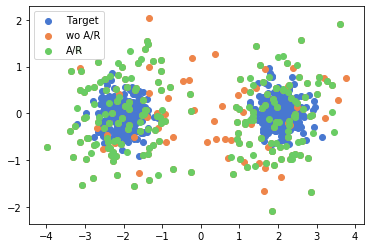

 22%|██▏       | 1100/5000 [07:07<25:13,  2.58it/s]

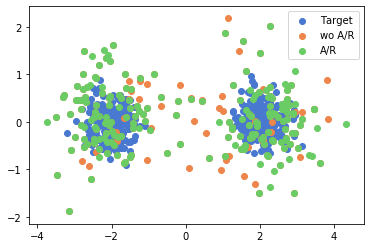

 22%|██▏       | 1101/5000 [07:08<27:19,  2.38it/s]

Step: 1100 / 5000, Loss: -8.38e+01, Acceptance sample: 0.80, LR: 0.00096


 23%|██▎       | 1150/5000 [07:26<24:32,  2.61it/s]

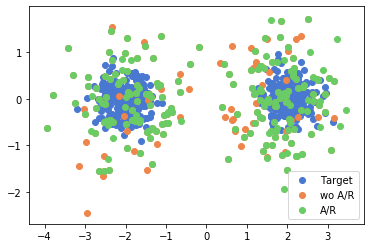

 24%|██▍       | 1200/5000 [07:46<24:15,  2.61it/s]

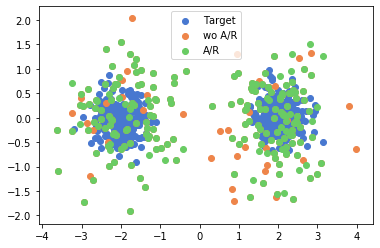

 24%|██▍       | 1201/5000 [07:46<26:36,  2.38it/s]

Step: 1200 / 5000, Loss: -7.64e+01, Acceptance sample: 0.79, LR: 0.00096


 25%|██▌       | 1250/5000 [08:05<23:38,  2.64it/s]

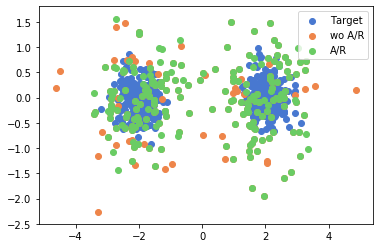

 26%|██▌       | 1300/5000 [08:24<23:22,  2.64it/s]

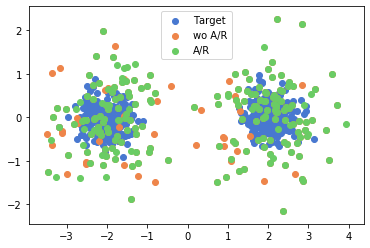

 26%|██▌       | 1301/5000 [08:24<25:23,  2.43it/s]

Step: 1300 / 5000, Loss: -8.17e+01, Acceptance sample: 0.78, LR: 0.00096


 27%|██▋       | 1350/5000 [08:43<23:52,  2.55it/s]

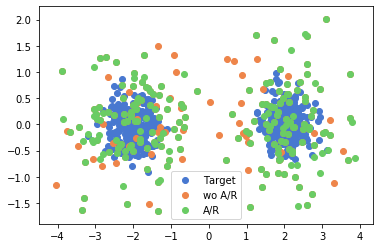

 28%|██▊       | 1400/5000 [09:02<22:41,  2.64it/s]

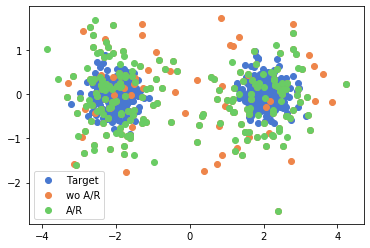

 28%|██▊       | 1401/5000 [09:03<25:02,  2.40it/s]

Step: 1400 / 5000, Loss: -7.94e+01, Acceptance sample: 0.77, LR: 0.00096


 29%|██▉       | 1450/5000 [09:21<22:46,  2.60it/s]

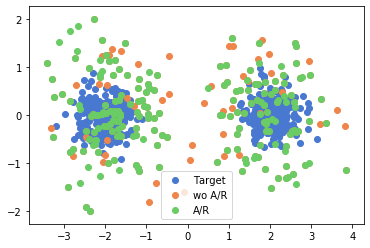

 30%|███       | 1500/5000 [09:41<22:18,  2.61it/s]

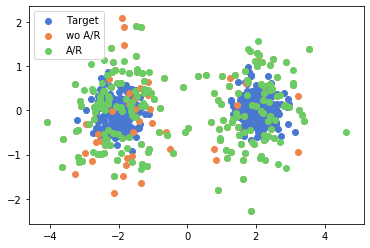

 30%|███       | 1501/5000 [09:41<24:01,  2.43it/s]

Step: 1500 / 5000, Loss: -8.96e+01, Acceptance sample: 0.77, LR: 0.00096


 31%|███       | 1550/5000 [10:00<21:59,  2.61it/s]

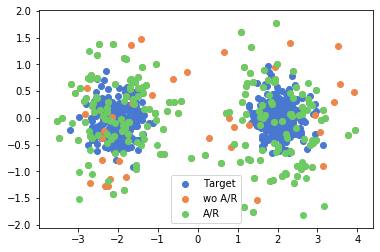

 32%|███▏      | 1600/5000 [10:20<22:04,  2.57it/s]

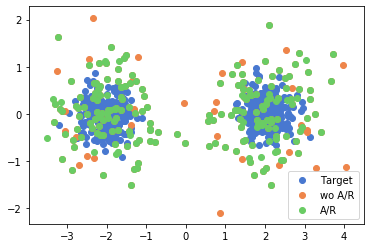

 32%|███▏      | 1601/5000 [10:20<23:44,  2.39it/s]

Step: 1600 / 5000, Loss: -7.36e+01, Acceptance sample: 0.80, LR: 0.00096


 33%|███▎      | 1650/5000 [10:39<21:50,  2.56it/s]

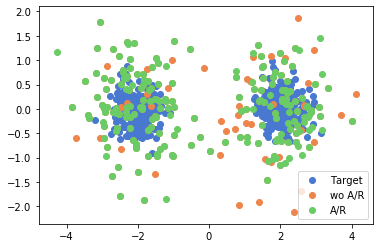

 34%|███▍      | 1700/5000 [10:59<21:11,  2.60it/s]

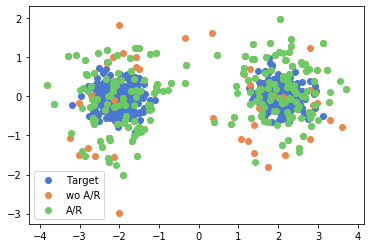

 34%|███▍      | 1701/5000 [10:59<22:55,  2.40it/s]

Step: 1700 / 5000, Loss: -8.07e+01, Acceptance sample: 0.79, LR: 0.00096


 35%|███▌      | 1750/5000 [11:18<20:51,  2.60it/s]

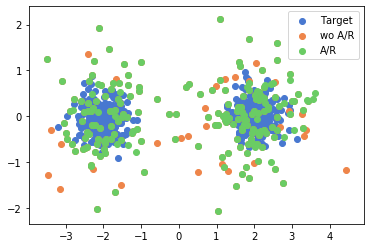

 36%|███▌      | 1800/5000 [11:37<20:46,  2.57it/s]

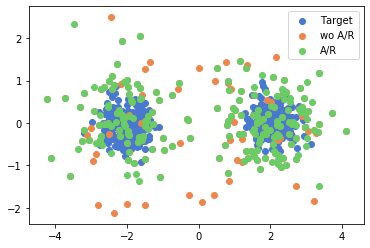

 36%|███▌      | 1801/5000 [11:38<22:15,  2.39it/s]

Step: 1800 / 5000, Loss: -8.87e+01, Acceptance sample: 0.77, LR: 0.00096


 37%|███▋      | 1850/5000 [11:57<20:29,  2.56it/s]

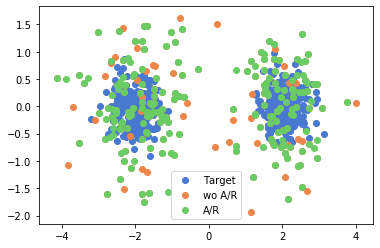

 38%|███▊      | 1900/5000 [12:16<20:03,  2.58it/s]

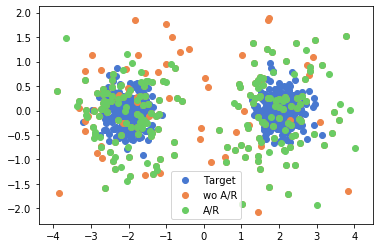

 38%|███▊      | 1901/5000 [12:17<21:56,  2.35it/s]

Step: 1900 / 5000, Loss: -8.27e+01, Acceptance sample: 0.76, LR: 0.00096


 39%|███▉      | 1950/5000 [12:36<19:29,  2.61it/s]

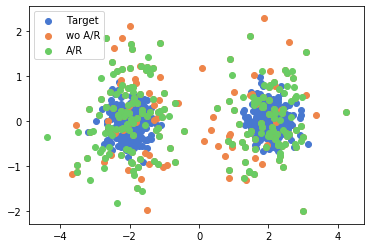

 40%|████      | 2000/5000 [12:55<19:32,  2.56it/s]

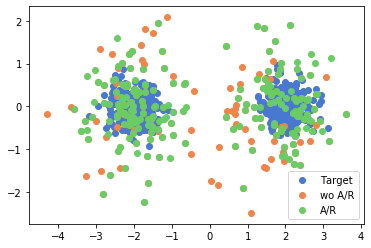

 40%|████      | 2001/5000 [12:56<21:07,  2.37it/s]

Step: 2000 / 5000, Loss: -7.63e+01, Acceptance sample: 0.72, LR: 0.00092


 41%|████      | 2050/5000 [13:15<19:08,  2.57it/s]

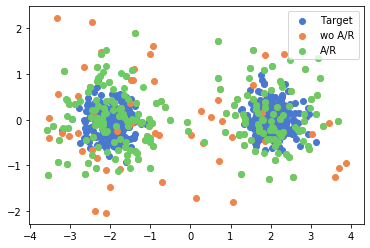

 42%|████▏     | 2100/5000 [13:35<18:48,  2.57it/s]

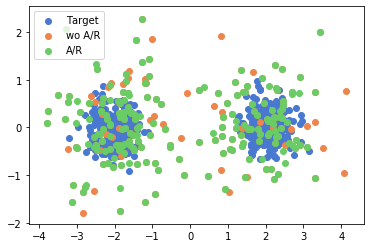

 42%|████▏     | 2101/5000 [13:35<20:28,  2.36it/s]

Step: 2100 / 5000, Loss: -9.00e+01, Acceptance sample: 0.78, LR: 0.00092


 43%|████▎     | 2150/5000 [13:54<18:27,  2.57it/s]

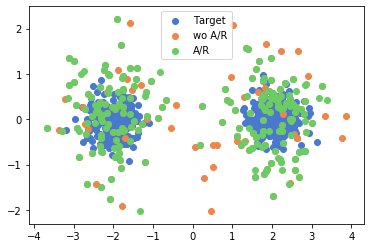

 44%|████▍     | 2200/5000 [14:14<17:56,  2.60it/s]

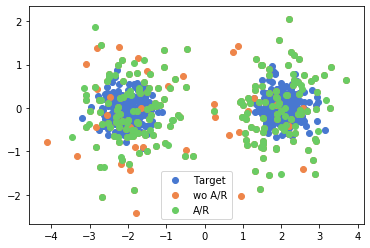

 44%|████▍     | 2201/5000 [14:14<19:33,  2.39it/s]

Step: 2200 / 5000, Loss: -8.86e+01, Acceptance sample: 0.79, LR: 0.00092


 45%|████▌     | 2250/5000 [14:33<17:50,  2.57it/s]

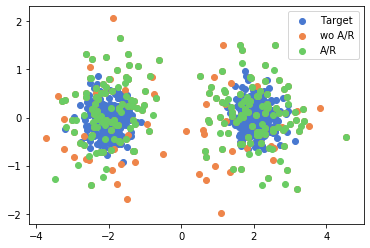

 46%|████▌     | 2300/5000 [14:53<17:22,  2.59it/s]

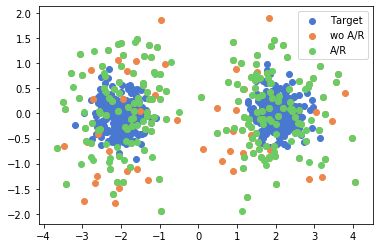

 46%|████▌     | 2301/5000 [14:53<18:47,  2.39it/s]

Step: 2300 / 5000, Loss: -9.02e+01, Acceptance sample: 0.75, LR: 0.00092


 47%|████▋     | 2350/5000 [15:12<17:05,  2.58it/s]

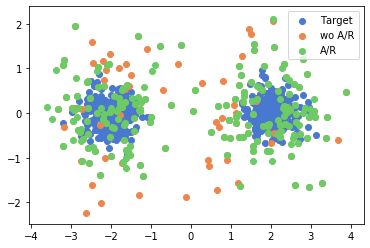

 48%|████▊     | 2400/5000 [15:32<16:42,  2.59it/s]

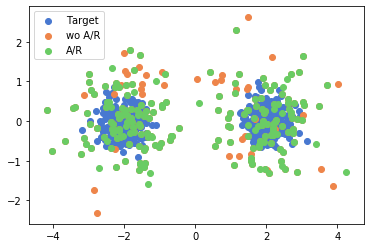

 48%|████▊     | 2401/5000 [15:32<17:57,  2.41it/s]

Step: 2400 / 5000, Loss: -8.80e+01, Acceptance sample: 0.80, LR: 0.00092


 49%|████▉     | 2450/5000 [15:51<16:27,  2.58it/s]

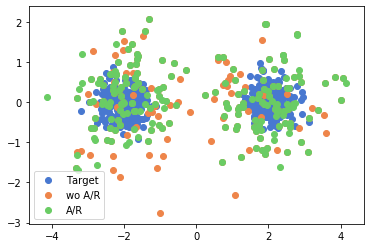

 50%|█████     | 2500/5000 [16:11<16:15,  2.56it/s]

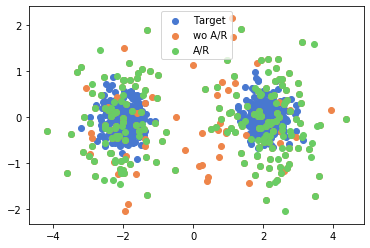

 50%|█████     | 2501/5000 [16:11<17:38,  2.36it/s]

Step: 2500 / 5000, Loss: -8.68e+01, Acceptance sample: 0.75, LR: 0.00092


 51%|█████     | 2550/5000 [16:30<15:52,  2.57it/s]

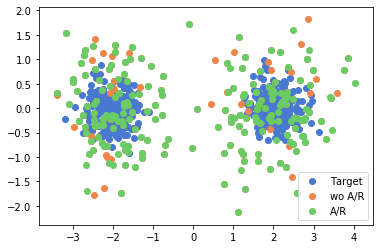

 52%|█████▏    | 2600/5000 [16:50<15:23,  2.60it/s]

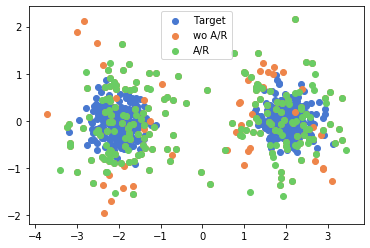

 52%|█████▏    | 2601/5000 [16:50<16:46,  2.38it/s]

Step: 2600 / 5000, Loss: -7.84e+01, Acceptance sample: 0.80, LR: 0.00092


 53%|█████▎    | 2650/5000 [17:09<15:09,  2.58it/s]

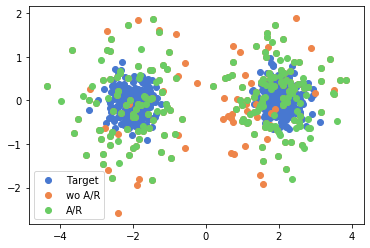

 54%|█████▍    | 2700/5000 [17:29<14:56,  2.56it/s]

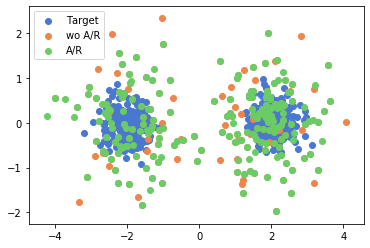

 54%|█████▍    | 2701/5000 [17:29<16:23,  2.34it/s]

Step: 2700 / 5000, Loss: -8.68e+01, Acceptance sample: 0.79, LR: 0.00092


 55%|█████▌    | 2750/5000 [17:48<14:32,  2.58it/s]

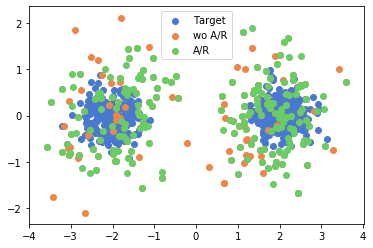

 56%|█████▌    | 2800/5000 [18:08<14:11,  2.58it/s]

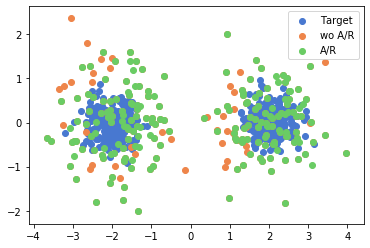

 56%|█████▌    | 2801/5000 [18:08<15:30,  2.36it/s]

Step: 2800 / 5000, Loss: -7.22e+01, Acceptance sample: 0.79, LR: 0.00092


 57%|█████▋    | 2850/5000 [18:27<13:45,  2.60it/s]

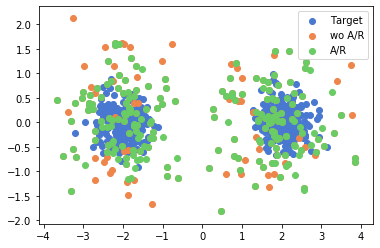

 58%|█████▊    | 2900/5000 [18:46<13:27,  2.60it/s]

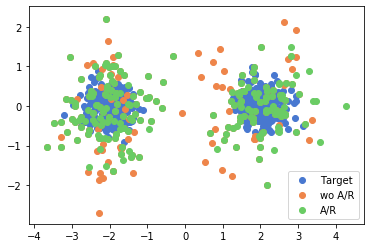

 58%|█████▊    | 2901/5000 [18:47<14:32,  2.41it/s]

Step: 2900 / 5000, Loss: -8.97e+01, Acceptance sample: 0.73, LR: 0.00092


 59%|█████▉    | 2950/5000 [19:06<13:07,  2.60it/s]

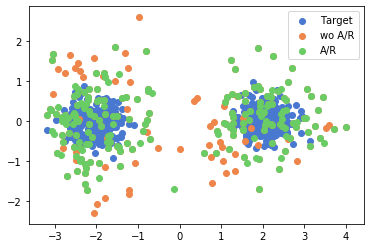

 60%|██████    | 3000/5000 [19:25<12:58,  2.57it/s]

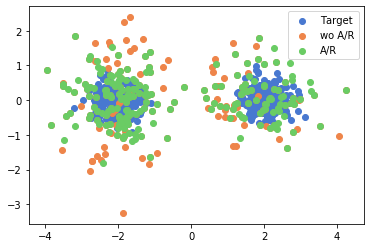

 60%|██████    | 3001/5000 [19:26<14:14,  2.34it/s]

Step: 3000 / 5000, Loss: -8.16e+01, Acceptance sample: 0.67, LR: 0.00088


 61%|██████    | 3050/5000 [19:45<12:31,  2.59it/s]

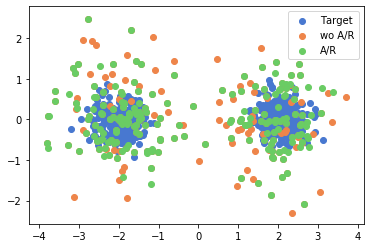

 62%|██████▏   | 3100/5000 [20:04<12:07,  2.61it/s]

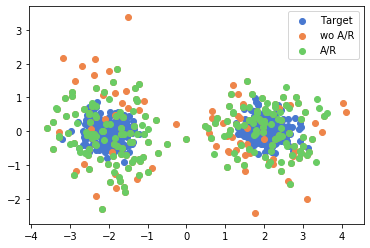

 62%|██████▏   | 3101/5000 [20:05<13:05,  2.42it/s]

Step: 3100 / 5000, Loss: -8.39e+01, Acceptance sample: 0.65, LR: 0.00088


 63%|██████▎   | 3150/5000 [20:24<11:54,  2.59it/s]

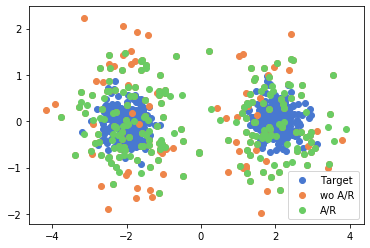

 64%|██████▍   | 3200/5000 [20:43<11:26,  2.62it/s]

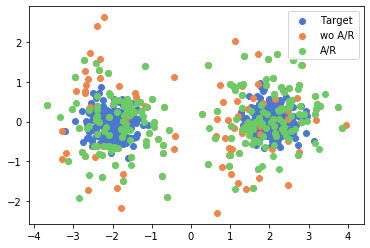

 64%|██████▍   | 3201/5000 [20:43<12:25,  2.41it/s]

Step: 3200 / 5000, Loss: -8.34e+01, Acceptance sample: 0.66, LR: 0.00088


 65%|██████▌   | 3250/5000 [21:02<11:13,  2.60it/s]

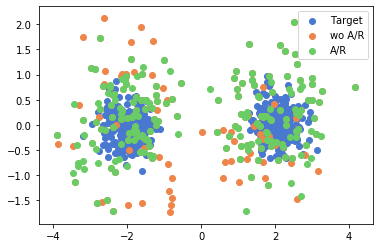

 66%|██████▌   | 3300/5000 [21:22<10:55,  2.59it/s]

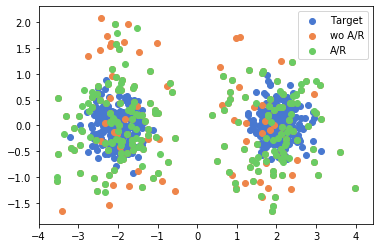

 66%|██████▌   | 3301/5000 [21:22<11:48,  2.40it/s]

Step: 3300 / 5000, Loss: -8.87e+01, Acceptance sample: 0.72, LR: 0.00088


 67%|██████▋   | 3350/5000 [21:42<10:38,  2.58it/s]

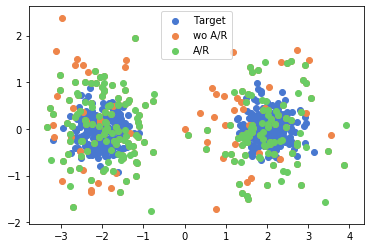

 68%|██████▊   | 3400/5000 [22:01<10:12,  2.61it/s]

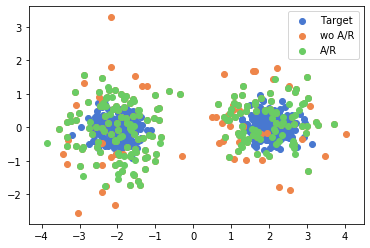

 68%|██████▊   | 3401/5000 [22:01<10:59,  2.42it/s]

Step: 3400 / 5000, Loss: -9.49e+01, Acceptance sample: 0.72, LR: 0.00088


 69%|██████▉   | 3450/5000 [22:20<09:57,  2.59it/s]

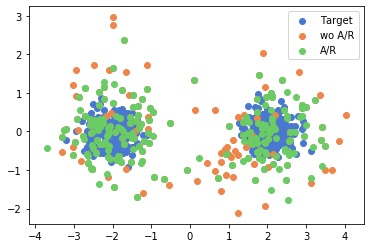

 70%|███████   | 3500/5000 [22:40<09:40,  2.58it/s]

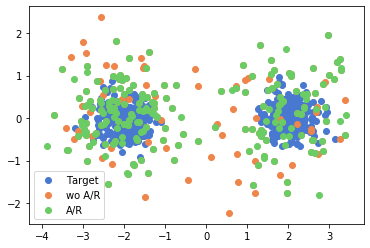

 70%|███████   | 3501/5000 [22:40<10:25,  2.40it/s]

Step: 3500 / 5000, Loss: -8.71e+01, Acceptance sample: 0.67, LR: 0.00088


 71%|███████   | 3550/5000 [22:59<09:23,  2.57it/s]

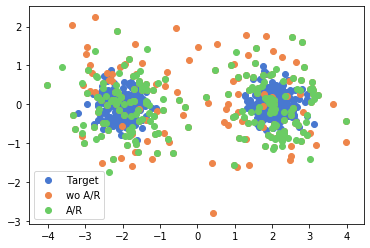

 72%|███████▏  | 3600/5000 [23:19<09:00,  2.59it/s]

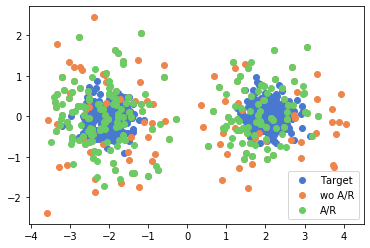

 72%|███████▏  | 3601/5000 [23:19<09:44,  2.39it/s]

Step: 3600 / 5000, Loss: -7.06e+01, Acceptance sample: 0.62, LR: 0.00088


 73%|███████▎  | 3650/5000 [23:39<08:43,  2.58it/s]

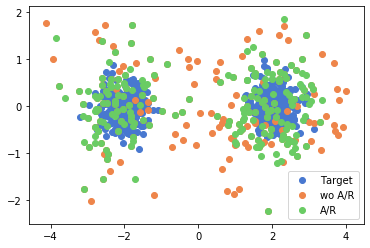

 74%|███████▍  | 3700/5000 [23:58<08:26,  2.56it/s]

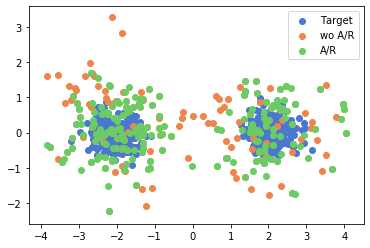

 74%|███████▍  | 3701/5000 [23:59<09:18,  2.32it/s]

Step: 3700 / 5000, Loss: -7.49e+01, Acceptance sample: 0.59, LR: 0.00088


 75%|███████▌  | 3750/5000 [24:18<08:05,  2.57it/s]

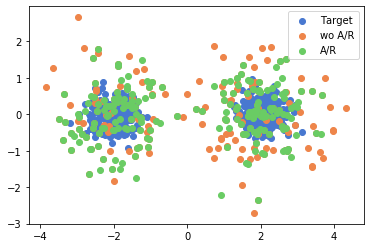

 76%|███████▌  | 3800/5000 [24:37<07:44,  2.58it/s]

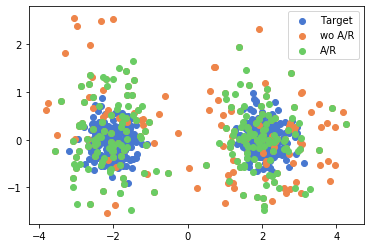

 76%|███████▌  | 3801/5000 [24:38<08:16,  2.41it/s]

Step: 3800 / 5000, Loss: -7.71e+01, Acceptance sample: 0.56, LR: 0.00088


 77%|███████▋  | 3850/5000 [24:56<07:20,  2.61it/s]

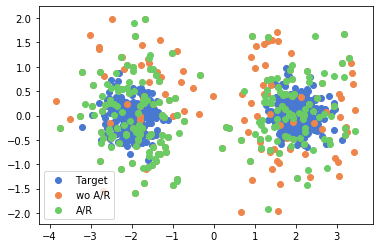

 78%|███████▊  | 3900/5000 [25:16<07:01,  2.61it/s]

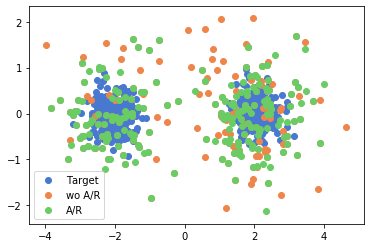

 78%|███████▊  | 3901/5000 [25:16<07:41,  2.38it/s]

Step: 3900 / 5000, Loss: -8.05e+01, Acceptance sample: 0.59, LR: 0.00088


 79%|███████▉  | 3950/5000 [25:35<06:43,  2.60it/s]

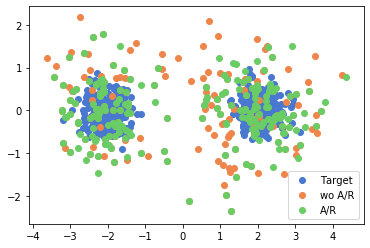

 80%|████████  | 4000/5000 [25:55<06:30,  2.56it/s]

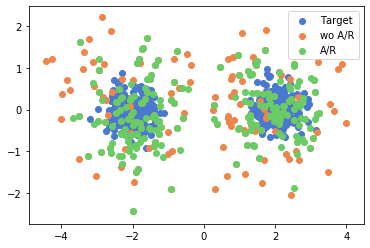

 80%|████████  | 4001/5000 [25:56<07:09,  2.33it/s]

Step: 4000 / 5000, Loss: -6.77e+01, Acceptance sample: 0.56, LR: 0.00085


 81%|████████  | 4050/5000 [26:15<06:07,  2.58it/s]

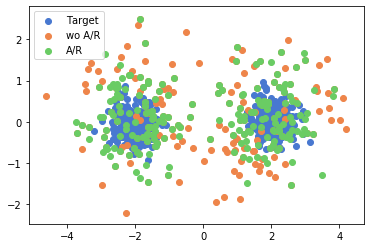

 82%|████████▏ | 4100/5000 [26:34<05:46,  2.60it/s]

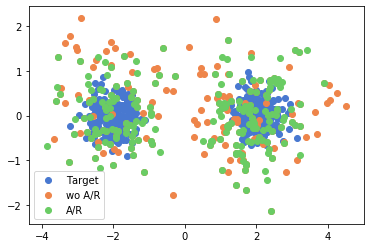

 82%|████████▏ | 4101/5000 [26:35<06:16,  2.39it/s]

Step: 4100 / 5000, Loss: -8.44e+01, Acceptance sample: 0.54, LR: 0.00085


 83%|████████▎ | 4150/5000 [26:53<05:28,  2.59it/s]

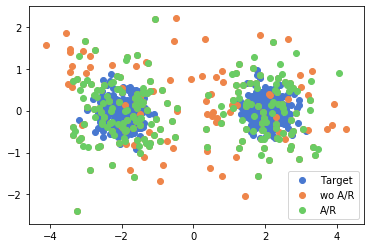

 84%|████████▍ | 4200/5000 [27:13<05:07,  2.60it/s]

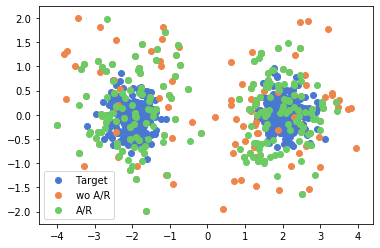

 84%|████████▍ | 4201/5000 [27:13<05:34,  2.39it/s]

Step: 4200 / 5000, Loss: -8.23e+01, Acceptance sample: 0.58, LR: 0.00085


 85%|████████▌ | 4250/5000 [27:32<04:52,  2.57it/s]

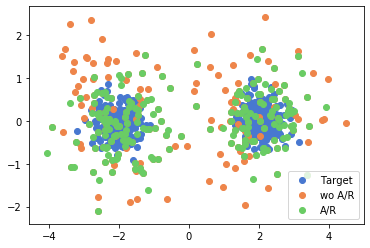

 86%|████████▌ | 4300/5000 [27:52<04:33,  2.56it/s]

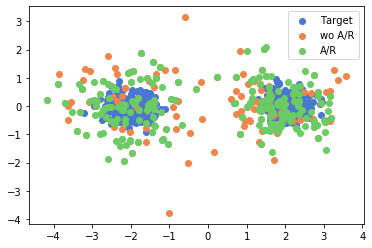

 86%|████████▌ | 4301/5000 [27:52<04:53,  2.38it/s]

Step: 4300 / 5000, Loss: -8.58e+01, Acceptance sample: 0.56, LR: 0.00085


 87%|████████▋ | 4350/5000 [28:11<04:03,  2.67it/s]

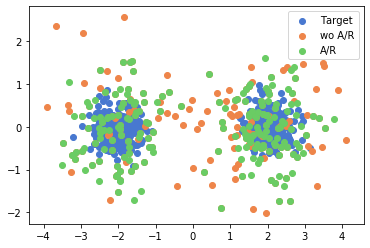

 88%|████████▊ | 4400/5000 [28:30<03:48,  2.62it/s]

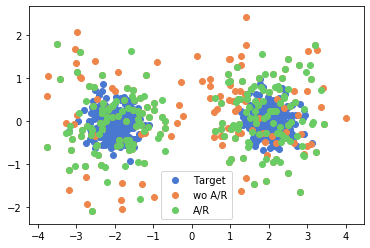

 88%|████████▊ | 4401/5000 [28:31<04:08,  2.41it/s]

Step: 4400 / 5000, Loss: -8.10e+01, Acceptance sample: 0.54, LR: 0.00085


 89%|████████▉ | 4450/5000 [28:49<03:28,  2.63it/s]

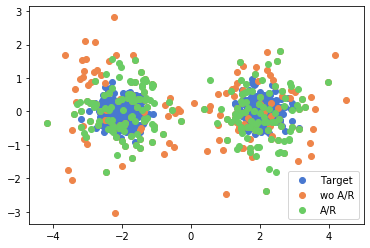

 90%|█████████ | 4500/5000 [29:09<03:09,  2.63it/s]

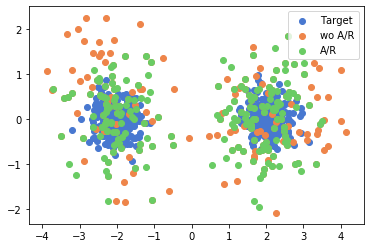

 90%|█████████ | 4501/5000 [29:09<03:27,  2.41it/s]

Step: 4500 / 5000, Loss: -9.19e+01, Acceptance sample: 0.58, LR: 0.00085


 91%|█████████ | 4550/5000 [29:28<02:50,  2.63it/s]

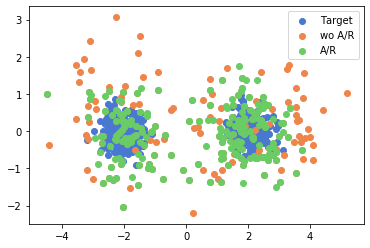

 92%|█████████▏| 4600/5000 [29:47<02:31,  2.63it/s]

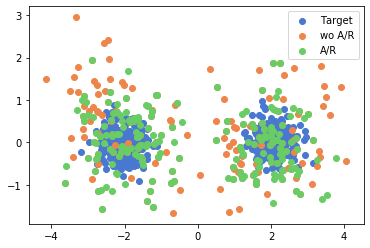

 92%|█████████▏| 4601/5000 [29:47<02:42,  2.45it/s]

Step: 4600 / 5000, Loss: -8.60e+01, Acceptance sample: 0.54, LR: 0.00085


 93%|█████████▎| 4650/5000 [30:06<02:12,  2.64it/s]

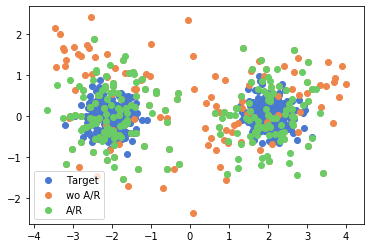

 94%|█████████▍| 4700/5000 [30:25<01:53,  2.64it/s]

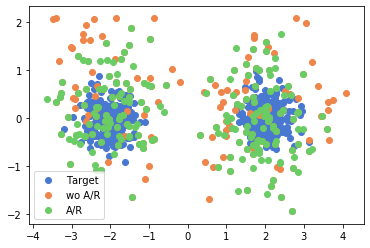

 94%|█████████▍| 4701/5000 [30:25<02:02,  2.44it/s]

Step: 4700 / 5000, Loss: -9.43e+01, Acceptance sample: 0.55, LR: 0.00085


 95%|█████████▌| 4750/5000 [30:44<01:34,  2.64it/s]

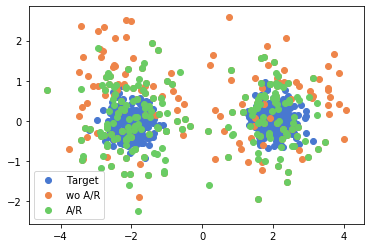

 96%|█████████▌| 4800/5000 [31:03<01:15,  2.64it/s]

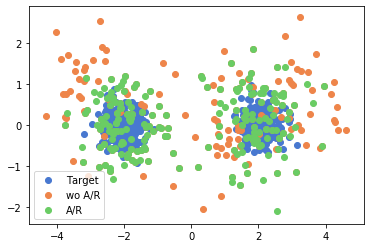

 96%|█████████▌| 4801/5000 [31:03<01:21,  2.43it/s]

Step: 4800 / 5000, Loss: -8.32e+01, Acceptance sample: 0.48, LR: 0.00085


 97%|█████████▋| 4850/5000 [31:22<00:56,  2.64it/s]

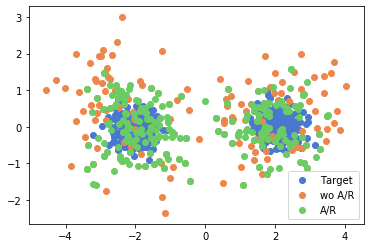

 98%|█████████▊| 4900/5000 [31:41<00:37,  2.64it/s]

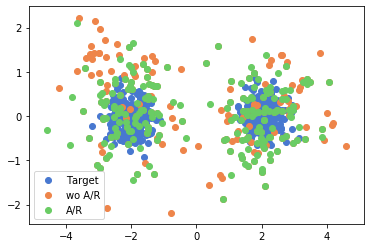

 98%|█████████▊| 4901/5000 [31:42<00:40,  2.45it/s]

Step: 4900 / 5000, Loss: -9.24e+01, Acceptance sample: 0.51, LR: 0.00085


 99%|█████████▉| 4950/5000 [32:00<00:18,  2.63it/s]

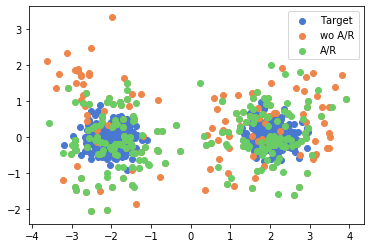

100%|██████████| 5000/5000 [32:19<00:00,  2.58it/s]


In [12]:
optim = Adam(dynamics.parameters())
scheduler = StepLR(optim, step_size=1000, gamma=0.96)
scale = torch.tensor(0.1, device=device)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

# with torch.autograd.detect_anomaly():
for t in tqdm(range(n_steps)):
    tmp = 9.0 * (1 - t / float(n_steps)) + 1
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    else:
        x = output[0].data #.to(device)

    z = torch.randn_like(x, device=device)

    optim.zero_grad()
    Lx, _, log_px, output, _, _ = propose(x, dynamics, do_mh_step=True, device=device, use_barker=use_barker)
    Lz, _, log_pz, _, _, _ = propose(z, dynamics, do_mh_step=False, device=device, use_barker=use_barker)
    
    if use_barker:
        px = log_px[0].exp()
        pz = log_pz[0].exp()
    else:
        px = log_px.exp()
        pz = log_pz.exp()

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4, device=device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4, device=device)
    
    
    if t % 50 == 0:
        plt.scatter(S[:, 0], S[:, 1], label='Target')
        plt.scatter(Lx.cpu().detach()[:, 0], Lx.cpu().detach()[:, 1], label='wo A/R')
        plt.scatter(output[0].cpu().detach()[:, 0], output[0].cpu().detach()[:, 1], label='A/R')
        plt.legend()
        plt.show();

    loss = criterion(v1, v2)
    
#     with torch.autograd.detect_anomaly():
#     set_trace()
    loss.backward()
    optim.step()
    
    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

In [13]:
length_of_chains = 800 #2000

In [14]:
samples = torch.tensor(dist.get_samples(n=n_samples), dtype=torch.float32, device=device)
final_samples = []

samples_ = samples
with torch.no_grad():
    for t in tqdm(range(length_of_chains)):
        final_samples.append(samples_.cpu().numpy())
        _, _, _, samples_, _, _ = propose(samples_, dynamics, do_mh_step=True, device=device)
        samples_ = samples_[0].detach()

100%|██████████| 800/800 [01:19<00:00, 10.04it/s]


In [15]:
L2HMC_samples = np.array(final_samples)
with torch.no_grad():
    HMC_samples_1 = get_hmc_samples(2, 0.1, dist.get_energy_function(), steps=length_of_chains, samples=samples, device=device)
    HMC_samples_2 = get_hmc_samples(2, 0.15, dist.get_energy_function(), steps=length_of_chains, samples=samples, device=device)
    HMC_samples_3 = get_hmc_samples(2, 0.2, dist.get_energy_function(), steps=length_of_chains, samples=samples, device=device)

100%|██████████| 800/800 [00:28<00:00, 27.63it/s]


In [16]:
L2HMC_samples.shape

(800, 200, 2)

In [17]:
HMC_samples_1.shape

(800, 200, 2)

In [18]:
cov_= np.array([[4.1, 0], [0, 0.1]])
scale = np.sqrt(np.trace(cov_))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

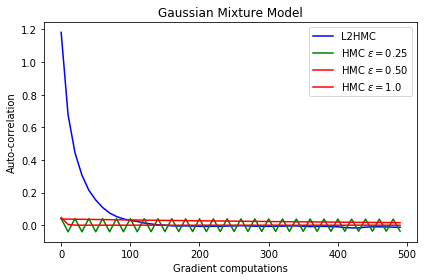

In [19]:
xaxis = 10 * np.arange(50)
fig = plt.figure()
plt.plot(xaxis, L2HMC[:50], label='L2HMC', color=c_l2hmc)
plt.plot(xaxis, HMC1[:50], label='HMC $\epsilon=0.25$', color=c_hmc2)
plt.plot(xaxis, HMC2[:50], label='HMC $\epsilon=0.50$', color=c_hmc3)
plt.plot(xaxis, HMC3[:50], label='HMC $\epsilon=1.0$', color=c_hmc3)
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient computations')
plt.title('Gaussian Mixture Model')
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('iso_gmm_plot.png', dpi=200)

In [20]:
# print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %.3f' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

### L2HMC samples overlayed on ground truth samples

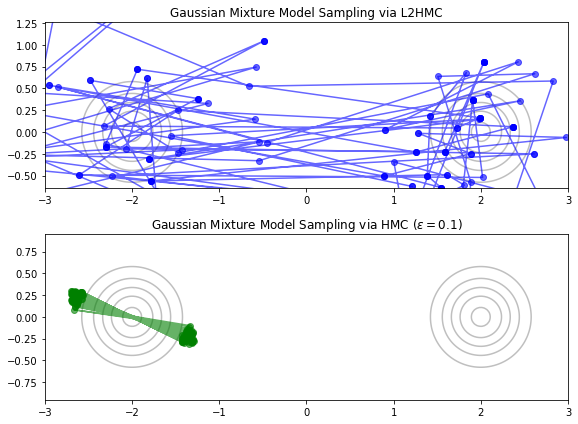

In [21]:
# plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=main)
fig = plt.figure(figsize=(8, 6))

points_to_plot = np.min([150, length_of_chains - 1])

ax1 = plt.subplot(2,1,1)
plot_gaussian_contours(mus.cpu().detach().numpy(),
                       covs.cpu().detach().numpy(), colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1], res=200)
plt.plot(L2HMC_samples[:points_to_plot, 1, 0], L2HMC_samples[:points_to_plot, 1, 1], color=c_l2hmc, marker='o', alpha=0.6)
plt.title('Gaussian Mixture Model Sampling via L2HMC')
plt.axis('equal')

ax2 = plt.subplot(2,1,2, sharex=ax1)
plot_gaussian_contours(mus.cpu().detach().numpy(),
                       covs.cpu().detach().numpy(), colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1], res=200)
plt.plot(HMC_samples_1[:points_to_plot, 1, 0], HMC_samples_1[:points_to_plot, 1, 1], color=c_hmc2, marker='o', alpha=0.6)
plt.title('Gaussian Mixture Model Sampling via HMC ($\epsilon = 0.1$)')
plt.axis('equal')
plt.tight_layout()

plt.axis([-3,3,-2,2])

plt.show()
# fig.savefig('iso_gmm_explore.png', dpi=200)

### HMC samples (Leapfrog step: ε = 0.15)

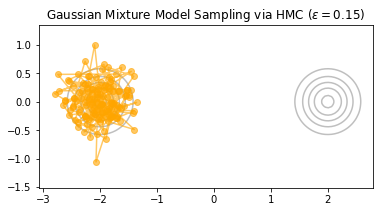

In [22]:
fig = plt.figure(figsize=(6, 3))
plot_gaussian_contours(mus.cpu().detach().numpy(),
                       covs.cpu().detach().numpy(), colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1], res=100)
plt.plot(HMC_samples_2[:points_to_plot, 1, 0], HMC_samples_2[:points_to_plot, 1, 1], color=c_hmc1, marker='o', alpha=0.6)
plt.xlim([-5,5])
plt.title('Gaussian Mixture Model Sampling via HMC ($\epsilon = 0.15$)')
plt.axis('equal')
plt.show()

### HMC samples (Leapfrog step: ε = 0.2)

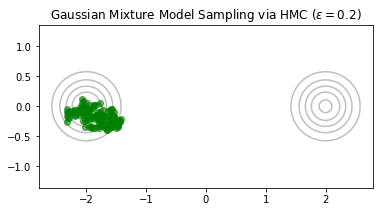

In [23]:
fig = plt.figure(figsize=(6, 3))
plot_gaussian_contours(mus.cpu().detach().numpy(),
                       covs.cpu().detach().numpy(), colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1])
plt.plot(HMC_samples_3[:points_to_plot, 1, 0], HMC_samples_3[:points_to_plot, 1, 1], color=c_hmc2, marker='o', alpha=0.6)
plt.title('Gaussian Mixture Model Sampling via HMC ($\epsilon = 0.2$)')
plt.axis('equal')
plt.show()